In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

In [2]:
data = pd.read_csv('retail_train.csv')
data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [3]:
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

In [4]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


### Задание 1. Подбор оптимальных гиперпараметров для ALS

- Попробуйте улучшить базовый вариант ALS, изменяя следующие параметры
  - regularization, iterations
  - factors
  - Вес (TF_IDF, BM25  взвешивание)
  
- Посчитайте метрики (Precision@5, MAP@5) для разных наборов гиперпараметров и выберете лучший набор

Определим функции для вычисления метрик:

In [5]:
def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)[:k]
    flags = np.isin(recommended_list, bought_list)
    
    precision = flags.sum() / len(recommended_list)
    
    return precision

In [8]:
def apk(recommended_list, bought_list, k=5):
  
    score = precision_at_k(recommended_list, bought_list, k=k)
 
    return score / min(len(bought_list), k)
 
def mapk(recommended_list, bought_list, k=5):
   
      return np.mean([apk(a,p,k) for a,p in zip(recommended_list, bought_list)])

И функцию для получения рекомендаций модели:

In [9]:
def get_recommendations(user, model, sparse_user_item, N=5):
    res = [id_to_itemid[rec] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item[userid_to_id[user]],   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=True)[0]]
    return res

Отберем 5000 самых популярных товаров:

In [11]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [12]:
# Заведем фиктивный item_id (если юзер покупал товары не из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробовать другие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head()

C:\Program Files\Anaconda\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

Проверим ALS модель для разных значений количества факторов

In [14]:
factors = [50, 75, 100, 125, 150]
p5 = []
map5= []

In [17]:
%%time
for val in factors:
    model = AlternatingLeastSquares(factors=val, 
                                regularization=0.01,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4,random_state=42)

    model.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)

    recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=sparse_user_item,   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=[itemid_to_id[999999]], 
                        recalculate_user=False)
    result['als'] = result['user_id'].map(lambda x: get_recommendations(x, model, sparse_user_item, N=5))
    p5.append(result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean())
    map5.append(result.apply(lambda row: apk(row['als'], row['actual']), axis=1).mean())
    
    


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Wall time: 58.1 s


In [18]:
p5

[0.1676787463271283,
 0.1880509304603304,
 0.18638589618021278,
 0.18315377081292594,
 0.1779627815866773,
 0.1676787463271283]

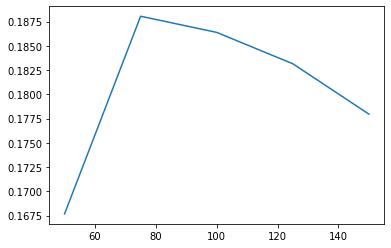

In [21]:
plt.plot(factors, p5[:5])

In [19]:
map5

[0.03425073457394676,
 0.03835292197192287,
 0.03807541625856988,
 0.03732941560561523,
 0.036230819458047465,
 0.03425073457394676]

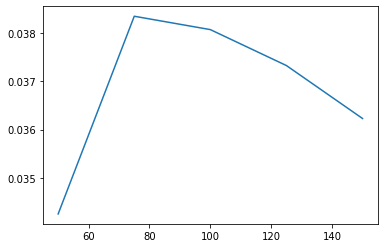

In [22]:
plt.plot(factors, map5[:5])

Как видно из графиков, наилучшие результаты по метрикам получились при параметре factors = 75.

Попробуем поменять величину регуляризации:

In [28]:
reg = [0.001, 0.005, 0.01, 0.05, 0.1]
p5 = []
map5= []

In [29]:
%%time
for val in reg:
    model = AlternatingLeastSquares(factors=75, 
                                regularization=val,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4,random_state=42)

    model.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)

    recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=sparse_user_item,   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=[itemid_to_id[999999]], 
                        recalculate_user=False)
    result['als'] = result['user_id'].map(lambda x: get_recommendations(x, model, sparse_user_item, N=5))
    p5.append(result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean())
    map5.append(result.apply(lambda row: apk(row['als'], row['actual']), axis=1).mean())

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Wall time: 53.6 s


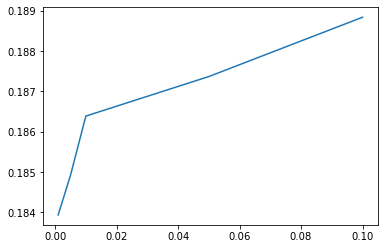

In [30]:
plt.plot(reg, p5)

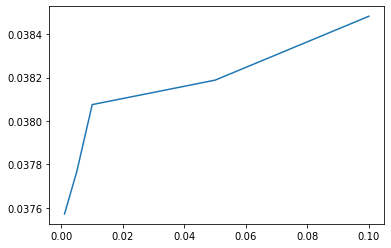

In [31]:
plt.plot(reg, map5)

Наилучшие результаты получились при регуляризации = 0.1

Проделаем то же самое для количества итераций:

In [33]:
iterations = [5, 10, 15, 20, 25]
p5 = []
map5= []

In [34]:
%%time
for val in iterations:
    model = AlternatingLeastSquares(factors=75, 
                                regularization=0.1,
                                iterations=val, 
                                calculate_training_loss=True, 
                                num_threads=4,random_state=42)

    model.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)

    recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=sparse_user_item,   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=[itemid_to_id[999999]], 
                        recalculate_user=False)
    result['als'] = result['user_id'].map(lambda x: get_recommendations(x, model, sparse_user_item, N=5))
    p5.append(result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean())
    map5.append(result.apply(lambda row: apk(row['als'], row['actual']), axis=1).mean())

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Wall time: 54.7 s


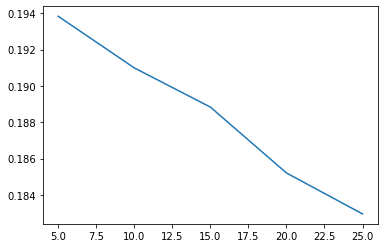

In [35]:
plt.plot(iterations, p5)

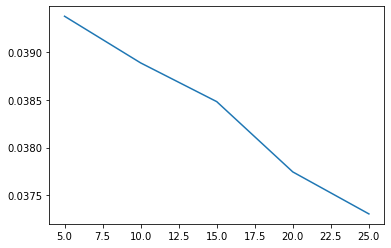

In [36]:
plt.plot(iterations, map5)

In [ ]:
При 5 итерациях алгоритм выдает наилучший результат.

Теперь попробуем другие методы взвешивания на уже найденных лучших гиперпараметрах:

In [37]:
tfidf_user_item_matrix = tfidf_weight(user_item_matrix).tocsr()


In [38]:
%%time

model = AlternatingLeastSquares(factors=75, 
                                regularization=0.1,
                                iterations=5, 
                                calculate_training_loss=True, 
                                num_threads=4,
                                random_state=42)

model.fit(tfidf_user_item_matrix,  # На вход item-user matrix
          show_progress=True)

result['als_tfidf'] = result['user_id'].map(lambda x: get_recommendations(x, model, sparse_user_item, N=5))

p5=result.apply(lambda row: precision_at_k(row['als_tfidf'], row['actual']), axis=1).mean()
map5=result.apply(lambda row: apk(row['als_tfidf'], row['actual']), axis=1).mean()

  0%|          | 0/5 [00:00<?, ?it/s]

Wall time: 7.5 s


In [39]:
p5, map5

(0.24446620959842968, 0.0495804766568727)

In [40]:
bm25_user_item_matrix = bm25_weight(user_item_matrix.T).T.tocsr()

In [41]:
%%time

model = AlternatingLeastSquares(factors=75, 
                                regularization=0.1,
                                iterations=5, 
                                calculate_training_loss=True, 
                                num_threads=4,
                                random_state=42)

model.fit(csr_matrix(bm25_user_item_matrix).tocsr(),  # На вход item-user matrix
          show_progress=True)

result['als_bm25'] = result['user_id'].map(lambda x: get_recommendations(x, model, sparse_user_item, N=5))

p5=result.apply(lambda row: precision_at_k(row['als_bm25'], row['actual']), axis=1).mean()
map5=result.apply(lambda row: apk(row['als_bm25'], row['actual']), axis=1).mean()

  0%|          | 0/5 [00:00<?, ?it/s]

Wall time: 7.45 s


In [43]:
p5, map5

(0.21400587659157388, 0.0432713026444663)

### Вывод:
Наилучшие результаты (presition@5 = 0.2445, map@5 = 0.0496) алгоритм ALS показал со следующими гиперпараметрами:

factors = 75, regularization = 0.1, iterations = 5, метод взвешивания - TF-IDF.